In [120]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from numpy import mean, std
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


READ DATASET


In [121]:
# Dict to store the model metrics like accuracy, f1, recall
metrics = {}

DATASET_PATH = "final-merged-dataset.csv"
df = pd.read_csv(DATASET_PATH)

# Initially set the clean_dataset as dataset itself. Using two variables clean_dataset
# and dataset to retain full dataset because after cleaning dataset we lose some data.
dataset = pd.read_csv(DATASET_PATH)
df


,Address A,Port A,Address B,Port B,Packets,Bytes,Packets A → B,Bytes A → B,Packets B → A,Bytes B → A,Rel Start,Duration,Bits/s A → B,Bits/s B → A,Target
0,192.168.0.103,58143.0,172.217.27.206,443.0,124.0,39548.0,58.0,24102.0,66.0,15446.0,2.189866,71.960428,2679.472668,1717.165996,1.0
1,192.168.0.103,57584.0,142.250.183.36,443.0,57.0,20695.0,28.0,6243.0,29.0,14452.0,3.438290,6.027378,8286.190115,19181.806750,1.0
2,192.168.0.103,56245.0,142.250.182.238,443.0,32.0,8167.0,16.0,3428.0,16.0,4739.0,6.224338,6.776927,4046.671891,5594.275990,1.0
3,192.168.0.103,52458.0,34.120.240.7,443.0,50.0,10723.0,27.0,5281.0,23.0,5442.0,6.231467,6.725964,6281.330081,6472.826795,1.0
4,192.168.0.103,64882.0,157.240.16.52,443.0,87.0,50414.0,41.0,17976.0,46.0,32438.0,6.413699,36.352234,3955.960451,7138.598415,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138096,192.168.1.7,63919.0,34.149.43.113,443.0,29.0,9133.0,18.0,2394.0,11.0,6739.0,14977.351270,112.948061,169.564664,477.316738,0.0
138097,192.168.1.7,63920.0,184.26.169.72,443.0,21.0,3153.0,10.0,1890.0,11.0,1263.0,15071.377690,180.212772,83.900824,56.067058,0.0
138098,192.168.1.7,63921.0,20.44.229.112,443.0,120.0,74957.0,68.0,42680.0,52.0,32277.0,15079.548760,180.737504,1889.148585,1428.679683,0.0
138099,192.168.1.7,63922.0,3.218.71.8,443.0,19.0,8424.0,10.0,1910.0,9.0,6514.0,15253.367570,3.271286,4670.945922,15930.126560,0.0


Data Sepecfications


Total packets: 138101
1.0    50482
0.0    41330
Name: Target, dtype: int64


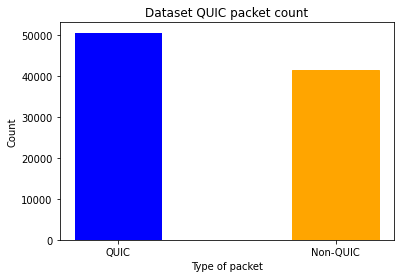

In [122]:
packet_protocol = df["Target"]
packet_protocol = ["QUIC" if x else "Non-QUIC" for x in packet_protocol]

print("Total packets: {0}".format(len(packet_protocol)))
print(df["Target"].value_counts())

# chart = sns.countplot(packet_protocol)
plt.title("Dataset QUIC packet count")
plt.xlabel("Type of packet")
plt.ylabel("Count")
# plt.show()

barlist = plt.bar(["QUIC", "Non-QUIC"], [50482, 41330], color="blue", width=0.4)
barlist[1].set_color("orange")
plt.show()


Data Pre-processing


In [123]:
def preprocess(df):
    # 1. Remove the strings columnns from dataset.
    df.drop(
        [
            "Address A",
            "Address B",
        ],
        axis=1,
        inplace=True,
    )
    print("Dropped strings...", df.size)

    # 2. Remove 'Unnamed' column from dataset. This comes from reading CSV.
    # https://stackoverflow.com/questions/43983622/remove-unnamed-columns-in-pandas-dataframe
    # df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    print("Dropped Unamed column...", df.size)

    # 3. Remove the invalid rows ie axis=0 from the dataset.
    df.dropna(axis=0, inplace=True)
    print("Dropped NA values...", df.size)

    # 4. After deleting the rows, shuffle and delete the index column.
    df = df.sample(frac=1).reset_index(drop=True)
    print("Shuffling Resetting index...", df.size)

    # 5. Get the result(quic) column values and remove dataset.
    targets = list(df["Target"].values)
    df.drop(df.columns[len(df.columns) - 1], axis=1, inplace=True)
    print("Dropped targets column...", df.size)

    return df, targets


initial_size = dataset.size
df, targets = preprocess(df)
final_size = df.size

if df.isnull().values.any():
    print("Failed to clean dataset. There are NaN/null values in dataset.")
    nan_cols = [i for i in df.columns if df[i].isnull().any()]
    print("Columns with null values: ", *nan_cols)
    exit(1)


print(
    "\nDataset size: {0} = {1}, Cleaned dataset size: {2} = {3}, Clean percentage: {4}%".format(
        dataset.shape,
        initial_size,
        df.shape,
        final_size,
        round(100 - (final_size / initial_size) * 100, 2),
    )
)

df


Dropped strings... 1795313
Dropped Unamed column... 1795313
Dropped NA values... 1193556
Shuffling Resetting index... 1193556
Dropped targets column... 1101744

Dataset size: (138101, 15) = 2071515, Cleaned dataset size: (91812, 12) = 1101744, Clean percentage: 46.81%


,Port A,Port B,Packets,Bytes,Packets A → B,Bytes A → B,Packets B → A,Bytes B → A,Rel Start,Duration,Bits/s A → B,Bits/s B → A
0,60503.0,53.0,2.0,249.0,1.0,91.0,1.0,158.0,3370.920000,0.000000,0.000000,0.000000e+00
1,52058.0,443.0,18.0,8980.0,9.0,3968.0,9.0,5012.0,8398.632591,15.148815,2095.477435,2.646808e+03
2,47877.0,443.0,16.0,9609.0,8.0,4310.0,8.0,5299.0,32283.813344,15.165977,2273.509976,2.795204e+03
3,62595.0,5355.0,2.0,168.0,2.0,168.0,0.0,0.0,571612.235097,0.101116,13291.665022,0.000000e+00
4,51269.0,443.0,20.0,12474.0,11.0,5823.0,9.0,6651.0,3894.087890,1.130764,41196.925265,4.705491e+04
...,...,...,...,...,...,...,...,...,...,...,...,...
91807,63837.0,443.0,4344.0,4356172.0,996.0,88275.0,3348.0,4267897.0,281.787219,3.475390,203200.216400,9.824272e+06
91808,56049.0,53.0,2.0,209.0,1.0,76.0,1.0,133.0,805.470000,0.000000,0.000000,0.000000e+00
91809,53172.0,19302.0,14.0,952.0,7.0,434.0,7.0,518.0,779345.734724,51.533692,67.373399,8.041341e+01
91810,38073.0,443.0,6.0,7070.0,6.0,7070.0,0.0,0.0,807141.714324,3.996474,14152.475407,0.000000e+00


Split train and test


In [124]:
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

X_train, X_test, Y_train, Y_test = train_test_split(
    df, targets, test_size=0.30, random_state=7, shuffle=True
)

X, Y = make_classification(
    n_samples=100, n_features=12, n_informative=12, n_redundant=0, random_state=7
)
cv = KFold(n_splits=4, random_state=7, shuffle=True)
cv

print("Size of test: {0}, {1}".format(len(X_test), len(Y_test)))
print("Size of train: {0}, {1}".format(len(X_train), len(Y_train)))


Size of test: 27544, 27544
Size of train: 64268, 64268


LOGISTIC REGRESSION


In [125]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(random_state=7)
clf = model.fit(X_train, Y_train)
predictions = clf.predict(X_test)

print(classification_report(Y_test, predictions))

score = model.score(X_test, Y_test) * 100
f1 = f1_score(Y_test, predictions) * 100
recall = recall_score(Y_test, predictions) * 100
precision = precision_score(Y_test, predictions) * 100

print("Accuracy: {0}%".format(score))
print("f1-score: {0}%".format(f1))
print("Accuracy: {0}%".format(recall))
print("Precision: {0}%".format(precision))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))

# Save the model to file.
joblib.dump(model, path.join("models", "LogisticRegression"))

metrics["LogisticRegression"] = {
    "Accuracy": score,
    "f1-score": f1,
    "Recall": recall,
    "Precision": precision,
    "CVAccuracy": mean(scores),
}


              precision    recall  f1-score   support

         0.0       0.66      0.81      0.73     12378
         1.0       0.81      0.67      0.73     15166

    accuracy                           0.73     27544
   macro avg       0.74      0.74      0.73     27544
weighted avg       0.74      0.73      0.73     27544

Accuracy: 73.05039209991287%
f1-score: 73.13913515469513%
Accuracy: 66.63589608334432%
Precision: 81.04900152377897%
CV Accuracy: 85.000 (0.017)


DECISION TREE


In [126]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))

score = model.score(X_test, Y_test) * 100
f1 = f1_score(Y_test, predictions) * 100
recall = recall_score(Y_test, predictions) * 100
precision = precision_score(Y_test, predictions) * 100

print("Accuracy: {0}%".format(score))
print("f1-score: {0}%".format(f1))
print("Accuracy: {0}%".format(recall))
print("Precision: {0}%".format(precision))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
metrics["DecisionTree"] = {
    "Accuracy": score,
    "f1-score": f1,
    "Recall": recall,
    "Precision": precision,
    "CVAccuracy": mean(scores),
}

# Save the model to file.
joblib.dump(model, path.join("models", "DecisionTree"))


              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90     12378
         1.0       0.92      0.90      0.91     15166

    accuracy                           0.91     27544
   macro avg       0.90      0.91      0.90     27544
weighted avg       0.91      0.91      0.91     27544

Accuracy: 90.51336044147546%
f1-score: 91.29377269849732%
Accuracy: 90.33364103916655%
Precision: 92.27453357580656%
CV Accuracy: 68.000 (0.040)


['models/DecisionTree']

GRADIENT BOOST


In [127]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))

score = model.score(X_test, Y_test) * 100
f1 = f1_score(Y_test, predictions) * 100
recall = recall_score(Y_test, predictions) * 100
precision = precision_score(Y_test, predictions) * 100


print("Accuracy: {0}%".format(score))
print("f1-score: {0}%".format(f1))
print("Accuracy: {0}%".format(recall))
print("Precision: {0}%".format(precision))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
metrics["GradientBoost"] = {
    "Accuracy": score,
    "f1-score": f1,
    "Recall": recall,
    "Precision": precision,
    "CVAccuracy": mean(scores),
}

# Save the model to file.
joblib.dump(model, path.join("models", "GradientBoost"))


              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92     12378
         1.0       0.95      0.92      0.93     15166

    accuracy                           0.93     27544
   macro avg       0.93      0.93      0.93     27544
weighted avg       0.93      0.93      0.93     27544

Accuracy: 92.94946267789719%
f1-score: 93.48933887622367%
Accuracy: 91.93590927073717%
Precision: 95.09616696221525%
CV Accuracy: 76.000 (0.075)


['models/GradientBoost']

KNN


In [128]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))

score = model.score(X_test, Y_test) * 100
f1 = f1_score(Y_test, predictions) * 100
recall = recall_score(Y_test, predictions) * 100
precision = precision_score(Y_test, predictions) * 100

print("Accuracy: {0}%".format(score))
print("f1-score: {0}%".format(f1))
print("Accuracy: {0}%".format(recall))
print("Precision: {0}%".format(precision))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
metrics["KNN"] = {
    "Accuracy": score,
    "f1-score": f1,
    "Recall": recall,
    "Precision": precision,
    "CVAccuracy": mean(scores),
}

# Save the model to file.
joblib.dump(model, path.join("models", "KNN"))


              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89     12378
         1.0       0.92      0.90      0.91     15166

    accuracy                           0.90     27544
   macro avg       0.90      0.90      0.90     27544
weighted avg       0.90      0.90      0.90     27544

Accuracy: 89.99056055765321%
f1-score: 90.842661175142%
Accuracy: 90.16879862851115%
Precision: 91.52667157486111%
CV Accuracy: 87.000 (0.052)


['models/KNN']

RANDOM FOREST


In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))

score = model.score(X_test, Y_test) * 100
f1 = f1_score(Y_test, predictions) * 100
recall = recall_score(Y_test, predictions) * 100
precision = precision_score(Y_test, predictions) * 100


print("Accuracy: {0}%".format(score))
print("f1-score: {0}%".format(f1))
print("Accuracy: {0}%".format(recall))
print("Precision: {0}%".format(precision))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
metrics["RandomForest"] = {
    "Accuracy": score,
    "f1-score": f1,
    "Recall": recall,
    "Precision": precision,
    "CVAccuracy": mean(scores),
}

# Save the model to file.
joblib.dump(model, path.join("models", "RandomForest"))


              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90     12378
         1.0       0.92      0.92      0.92     15166

    accuracy                           0.91     27544
   macro avg       0.91      0.91      0.91     27544
weighted avg       0.91      0.91      0.91     27544

Accuracy: 90.95628812082485%
f1-score: 91.77317612867006%
Accuracy: 91.61281814585257%
Precision: 91.93409647323496%
CV Accuracy: 81.000 (0.077)


['models/RandomForest']

Feature importance for random forest


Port A           0.036363
Port B           0.035276
Packets          0.050140
Bytes            0.080625
Packets A → B    0.026901
Bytes A → B      0.144353
Packets B → A    0.058804
Bytes B → A      0.126608
Rel Start        0.079383
Duration         0.086285
Bits/s A → B     0.087558
Bits/s B → A     0.187704
dtype: float64


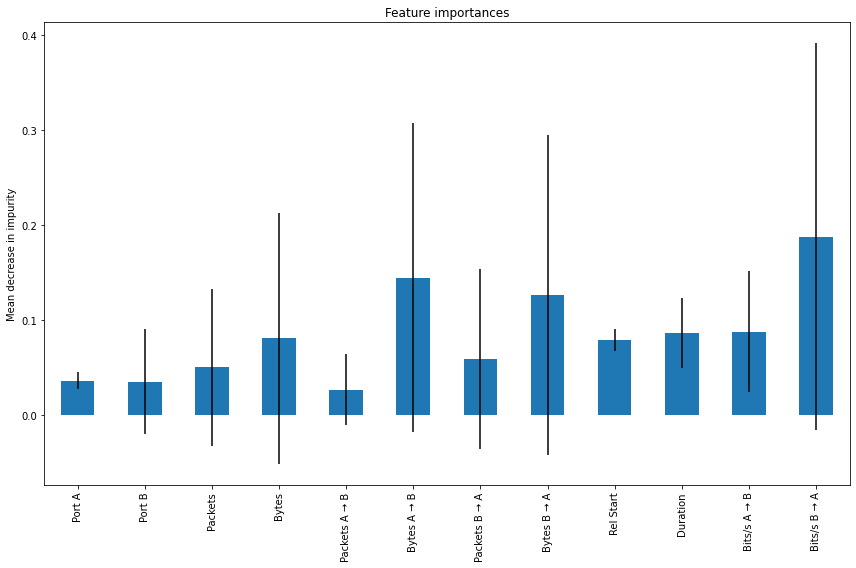

In [130]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

features = list(df.columns)
classifier_importances = pd.Series(importances, index=features)
print(classifier_importances)

fig, ax = plt.subplots()
classifier_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout(rect=(0, 0, 2, 2))
plt.show()


ACCURACY


LogisticRegression                  73.05039209991287%
DecisionTree                        90.51336044147546%
GradientBoost                       92.94946267789719%
KNN                                 89.99056055765321%
RandomForest                        90.95628812082485%


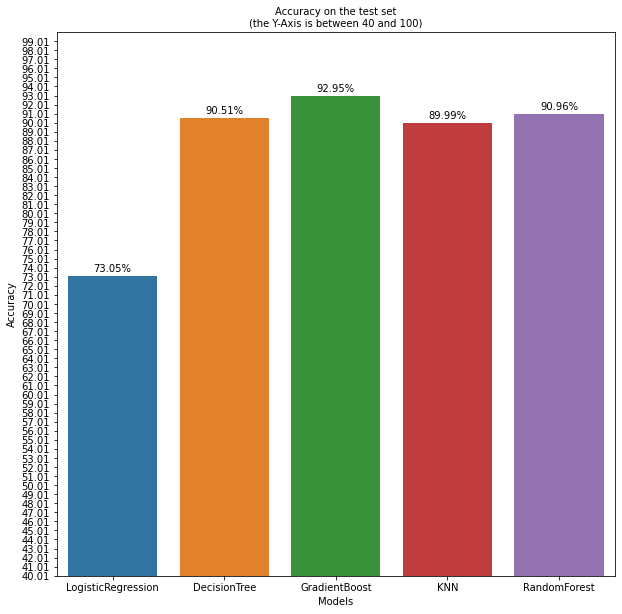

In [131]:
ticks = []
accuracy = []
models_accuracy = []

for k, v in metrics.items():
    accuracy.append(v["Accuracy"])
    models_accuracy.append(
        [k, v["Accuracy"], v["f1-score"], v["Recall"], v["Precision"]]
    )
    print("{0:<35} {1}%".format(k, v["Accuracy"]))

df_acc = pd.DataFrame(models_accuracy)
df_acc.columns = ["Models", "Accuracy", "f1-score", "Recall", "Precision"]

plt.figure(figsize=(10, 10))
g = sns.barplot(x="Models", y="Accuracy", data=df_acc)
for i in range(0, 100):
    val = i + 0.01
    ticks.append(val)
g.set_yticks(ticks)
g.set_yticklabels(ticks)

plt.title("Accuracy on the test set\n(the Y-Axis is between 40 and 100)", fontsize=10)
plt.ylim(40, 100)
for i, p in enumerate(g.patches):
    percentage = "{:.2f}%".format(accuracy[i])
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height() + 0.5
    g.annotate(percentage, (x, y), ha="center")

plt.show()


CROSS-VALIDATION ACCURACY

LogisticRegression                  85.0%
DecisionTree                        68.0%
GradientBoost                       76.0%
KNN                                 87.0%
RandomForest                        81.0%


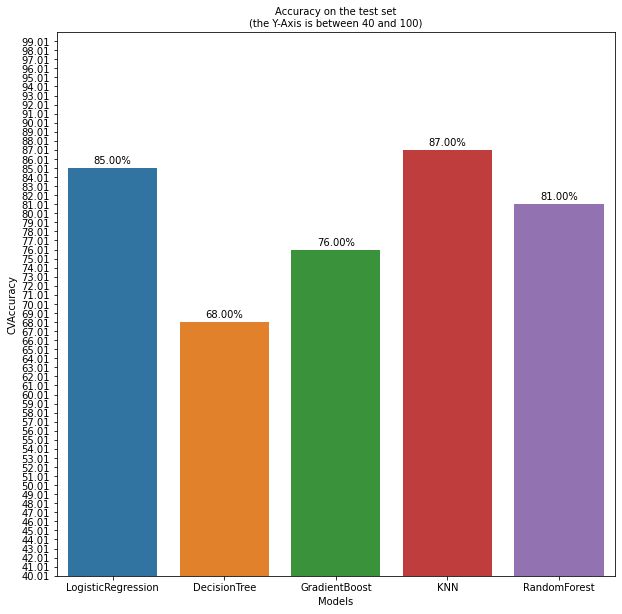

In [132]:
ticks = []
cvaccuracy = []
models_cvaccuracy = []
for k, v in metrics.items():
    try:
        cvaccuracy.append(v["CVAccuracy"] * 100)
        models_cvaccuracy.append([k, v["CVAccuracy"] * 100])
        print("{0:<35} {1}%".format(k, v["CVAccuracy"] * 100))

    except KeyError:
        cvaccuracy.append(10.30)
        models_cvaccuracy.append(10.30)
        print("{0:<35} {1}%".format(k, 1.03))
        continue


df_acc2 = pd.DataFrame(models_cvaccuracy)
df_acc2.columns = ["Models", "CVAccuracy"]

plt.figure(figsize=(10, 10))
g = sns.barplot(x="Models", y="CVAccuracy", data=df_acc2)
for i in range(0, 100):
    val = i + 0.01
    ticks.append(val)
g.set_yticks(ticks)
g.set_yticklabels(ticks)

plt.title("Accuracy on the test set\n(the Y-Axis is between 40 and 100)", fontsize=10)
plt.ylim(40, 100)
for i, p in enumerate(g.patches):
    percentage = "{:.2f}%".format(cvaccuracy[i])
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height() + 0.5
    g.annotate(percentage, (x, y), ha="center")

plt.show()


In [133]:
df_acc.head()


,Models,Accuracy,f1-score,Recall,Precision
0,LogisticRegression,73.050392,73.139135,66.635896,81.049002
1,DecisionTree,90.513360,91.293773,90.333641,92.274534
2,GradientBoost,92.949463,93.489339,91.935909,95.096167
3,KNN,89.990561,90.842661,90.168799,91.526672
4,RandomForest,90.956288,91.773176,91.612818,91.934096


<AxesSubplot:xlabel='Models'>

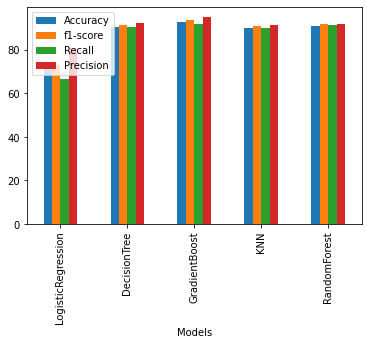

In [134]:
df_acc.plot(x="Models", y=["Accuracy", "f1-score", "Recall", "Precision"], kind="bar")


CNN


In [135]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


In [136]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
Y1 = np.array(targets).reshape(-1, 1)
Y1 = ohe.fit_transform(Y1).toarray()


In [137]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df, Y1, test_size=0.20, random_state=7, shuffle=True
)


In [138]:
import tensorflow as tf

# tf.config.run_functions_eagerly(True)
# X_train = X_train
# X_train = X_train.values.reshape(-1,1,16)
X_train = np.expand_dims(X_train, axis=1)


def make_model(input_shape):
    # X_test=X_test.reshape(-1,1,16)
    # Y_test=Y_test.reshape(-1,2)

    input_layer = keras.layers.Input(input_shape)
    # X_test=X_test.reshape(-1,1,16)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    gap = keras.layers.GlobalAveragePooling1D()(conv1)
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    gap = keras.layers.GlobalAveragePooling1D()(conv2)
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(2, activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
tf.keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [139]:
from tensorflow.keras.optimizers import SGD

opt = SGD(learning_rate=0.01)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["binary_accuracy"]
)


In [140]:
epochs = 100
batch_size = 32


In [141]:
Y_test = np.array(Y_test)


In [142]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/100
1837/1837 [==============================] - 6s 2ms/step - loss: 0.4785 - binary_accuracy: 0.7459 - val_loss: 2.1275 - val_binary_accuracy: 0.5403
Epoch 2/100
1837/1837 [==============================] - 3s 2ms/step - loss: 0.4318 - binary_accuracy: 0.7754 - val_loss: 2.1125 - val_binary_accuracy: 0.5406
Epoch 3/100
1837/1837 [==============================] - 4s 2ms/step - loss: 0.4104 - binary_accuracy: 0.7876 - val_loss: 2.3023 - val_binary_accuracy: 0.5402
Epoch 4/100
1837/1837 [==============================] - 4s 2ms/step - loss: 0.4003 - binary_accuracy: 0.7976 - val_loss: 2.3956 - val_binary_accuracy: 0.5410
Epoch 5/100
1837/1837 [==============================] - 4s 2ms/step - loss: 0.3923 - binary_accuracy: 0.8079 - val_loss: 2.6640 - val_binary_accuracy: 0.5411
Epoch 6/100
1837/1837 [==============================] - 3s 2ms/step - loss: 0.3854 - binary_accuracy: 0.8079 - val_loss: 2.4669 - val_binary_accuracy: 0.5409
Epoch 7/100
1837/1837 [=======================

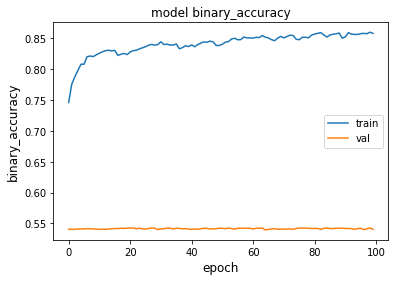

In [143]:
metric = "binary_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


In [144]:
X_train.shape


(73449, 1, 12)

In [145]:
Y_train.shape


(73449, 2)

In [146]:
n_timesteps, n_features, n_outputs = X_train.shape[0], X_train.shape[1], Y_train.shape[1]


In [147]:
X_train = X_train.values.reshape(-1, 1, 12)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(10, 128)))
model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(n_outputs, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
verbose, epochs, batch_size = 0, 10, 32


In [ ]:
X_train.shape


In [ ]:
X_train = X_train.reshape(-1, 1, 12)


In [ ]:
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)


In [ ]:
model2 = Sequential()
model2.add(
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(8, 8, 1), padding="same")
)
model2.add(layers.MaxPooling2D((1, 1), padding="same"))
model2.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model2.add(layers.MaxPooling2D((2, 2), padding="same"))
model2.add(layers.Conv2D(16, (3, 3), activation="softmax", padding="same"))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation="relu"))
model2.add(layers.Dense(2))


In [ ]:
model2.summary()
